Phase 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    average_precision_score
)

pd.set_option("display.max_columns", 200)


In [2]:
FILE_PATH = "/content/lendingclub_raw_accepted.csv"

df = pd.read_csv(FILE_PATH, low_memory=False)
print("Raw shape:", df.shape)


Raw shape: (366823, 151)


In [8]:
df = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
print("After filtering outcomes:", df.shape)


After filtering outcomes: (325878, 152)


In [9]:
df["default_6m"] = (df["loan_status"] == "Charged Off").astype(int)

print(df["default_6m"].value_counts())
print(df["default_6m"].value_counts(normalize=True))


default_6m
0    259955
1     65923
Name: count, dtype: int64
default_6m
0    0.797707
1    0.202293
Name: proportion, dtype: float64


In [10]:
EWS_FEATURES = [
    # Payment behavior
    "last_pymnt_amnt",
    "total_rec_prncp",
    "total_rec_int",
    "out_prncp",

    # Delinquency
    "mths_since_last_delinq",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",

    # Utilization
    "revol_util",
    "bc_util",
    "all_util",

    # Credit activity
    "mo_sin_rcnt_tl",
    "inq_last_12m",
    "acc_open_past_24mths",

    # Controls
    "annual_inc",
    "dti",
    "fico_range_low"
]


In [11]:
df_model = df[EWS_FEATURES + ["default_6m"]].copy()
print("Model dataset shape:", df_model.shape)


Model dataset shape: (325878, 17)


In [12]:
for col in EWS_FEATURES:
    df_model[col] = df_model[col].fillna(df_model[col].median())


Phase 2

In [13]:
X = df_model.drop(columns="default_6m")
y = df_model["default_6m"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(244408, 16) (81470, 16)


In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
ews_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

ews_model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [16]:
y_prob = ews_model.predict_proba(X_test_scaled)[:, 1]


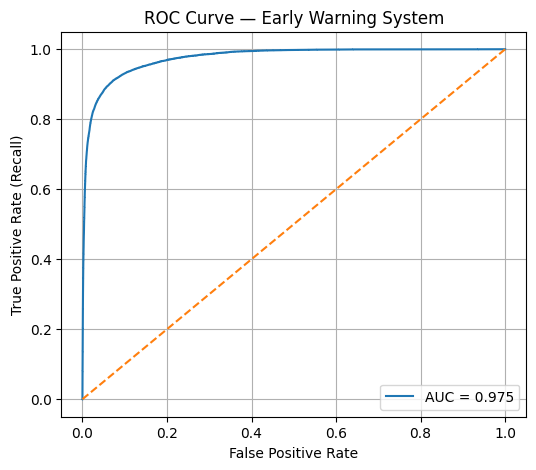

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Early Warning System")
plt.legend()
plt.grid(True)
plt.show()



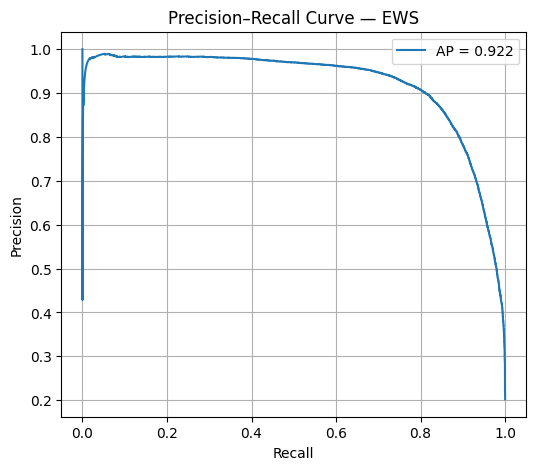

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — EWS")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
pr_table = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

pr_table.head()


,threshold,precision,recall
0,1.064979e-27,0.202295,1.0
1,1.188875e-27,0.202298,1.0
2,1.304168e-27,0.202300,1.0
3,1.553133e-27,0.202303,1.0
4,1.622162e-27,0.202305,1.0


In [23]:
alert_threshold = np.quantile(y_prob, 0.70)
print("Alert threshold:", round(alert_threshold, 3))


Alert threshold: 0.435


In [24]:
y_alert = (y_prob >= alert_threshold).astype(int)

print(classification_report(y_test, y_alert))


              precision    recall  f1-score   support

           0       0.98      0.86      0.92     64989
           1       0.64      0.95      0.76     16481

    accuracy                           0.88     81470
   macro avg       0.81      0.91      0.84     81470
weighted avg       0.92      0.88      0.89     81470



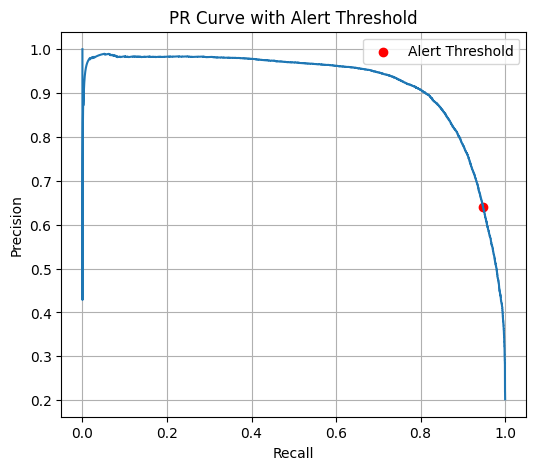

In [25]:
idx = np.argmin(np.abs(thresholds - alert_threshold))

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.scatter(
    recall[idx],
    precision[idx],
    color="red",
    label="Alert Threshold"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve with Alert Threshold")
plt.legend()
plt.grid(True)
plt.show()
